# Baseline Photo Modelling Example

In [1]:
import sys
import os
print(f"Python version: {sys.version}")
print(f"Working directory: {os.getcwd()}")
print("-" * 50)

Python version: 3.12.0 (main, May 18 2025, 17:01:09) [Clang 16.0.0 (clang-1600.0.26.6)]
Working directory: /Users/davidcurrymaster/Documents/projects/data-tools/notebooks
--------------------------------------------------


In [18]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

sys.path.append(os.path.abspath('..'))
import src.data_tools as data_tools
import src.photo_tools as photo_tools

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [5]:
df = pd.read_csv('../data/processed/test_data_with_images.csv')
print(f"Loaded {len(df)} rows with images")

Loaded 50 rows with images


# Feature Processing

In [6]:
# Function to extract basic features from images
def extract_image_features(image_path):
    """
    Extract basic features from an image
    """
    try:
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Basic statistics
        features = {
            'mean_r': img_rgb[:,:,0].mean(),
            'mean_g': img_rgb[:,:,1].mean(),
            'mean_b': img_rgb[:,:,2].mean(),
            'std_r': img_rgb[:,:,0].std(),
            'std_g': img_rgb[:,:,1].std(),
            'std_b': img_rgb[:,:,2].std(),
            'brightness': img_rgb.mean(),
            'contrast': img_rgb.std(),
        }
        
        # Color histogram features
        for i, color in enumerate(['r', 'g', 'b']):
            hist = cv2.calcHist([img_rgb], [i], None, [8], [0, 256])
            hist = hist.flatten() / hist.sum()
            for j, val in enumerate(hist):
                features[f'hist_{color}_{j}'] = val
        
        # Edge detection features
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        features['edge_density'] = edges.mean() / 255.0
        
        return features
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [7]:
# Extract features for all images
image_features = []
for idx, row in df.iterrows():
    features = extract_image_features(row['path'])
    if features:
        features['image_id'] = row['image_id']
        image_features.append(features)

# Create features dataframe
image_features_df = pd.DataFrame(image_features)
print(f"Extracted features for {len(image_features_df)} images")

# Merge with original data
df_with_features = df.merge(image_features_df, on='image_id')
print(f"Combined dataset shape: {df_with_features.shape}")

Extracted features for 50 images
Combined dataset shape: (50, 62)


In [8]:
df_with_features.head()

age  annual_income  credit_score  transaction_amount  product_views gender  \
0   28   83727.997743     49.444448          587.185346        0.00000      M   
1   37   22890.711694     41.253838          197.826427        0.00000      M   
2   45   37105.061624     41.113036          604.414719        0.00000  Other   
3   33   55483.632278     46.269633           21.721193       41.48655      F   
4   57   27243.393419     48.753416           43.158406        0.00000      M   

  state customer_id membership_level account_created  ...  hist_g_7  hist_b_0  \
0    NY  CUST000383              NaN      2024-05-04  ...       0.0  0.198591   
1    IL  CUST000039           Silver      2024-07-24  ...       0.0  0.195492   
2    NC  CUST000489             Gold      2022-09-05  ...       0.0  0.195836   
3    IL  CUST000042             Gold      2023-12-12  ...       0.0  0.195382   
4    MI  CUST000387             Gold      2021-08-16  ...       0.0  0.197273   

   hist_b_1  hist_b_2  hist_b_3  hist_b_4  hist_b_5  hist_b_6  hist_b_7  \
0  0.549700  0.244472  0.007237       0.0       0.0       0.0       0.0   
1  0.545400  0.251594  0.007514       0.0       0.0       0.0       0.0   
2  0.548288  0.248134  0.007743       0.0       0.0       0.0       0.0   
3  0.545654  0.250837  0.008126       0.0       0.0       0.0       0.0   
4  0.548576  0.245903  0.008247       0.0       0.0       0.0       0.0   

  edge_density  
0     0.246565  
1     0.248027  
2     0.250070  
3     0.241821  
4     0.244682  

[5 rows x 62 columns]

# SIGNAL DETECTION: Test Feature Correlation with Target

In [10]:
# Select image feature columns
image_feature_cols = [col for col in df_with_features.columns 
                     if col.startswith(('mean_', 'std_', 'hist_', 'brightness', 'contrast', 'edge_'))]

# Find signal strength of image features
image_signal_strength = data_tools.find_signal_strength(
    df_with_features[image_feature_cols + ['target']], 
    'target'
)

print("Top 10 Image Features by Signal Strength:")
print(image_signal_strength.head(10))

Error processing hist_r_4: Bin labels must be one fewer than the number of bin edges
Error processing hist_r_5: Bin labels must be one fewer than the number of bin edges
Error processing hist_r_6: Bin labels must be one fewer than the number of bin edges
Error processing hist_r_7: Bin labels must be one fewer than the number of bin edges
Error processing hist_g_4: Bin labels must be one fewer than the number of bin edges
Error processing hist_g_5: Bin labels must be one fewer than the number of bin edges
Error processing hist_g_6: Bin labels must be one fewer than the number of bin edges
Error processing hist_g_7: Bin labels must be one fewer than the number of bin edges
Error processing hist_b_2: Bin labels must be one fewer than the number of bin edges
Error processing hist_b_4: Bin labels must be one fewer than the number of bin edges
Error processing hist_b_5: Bin labels must be one fewer than the number of bin edges
Error processing hist_b_6: Bin labels must be one fewer than the 

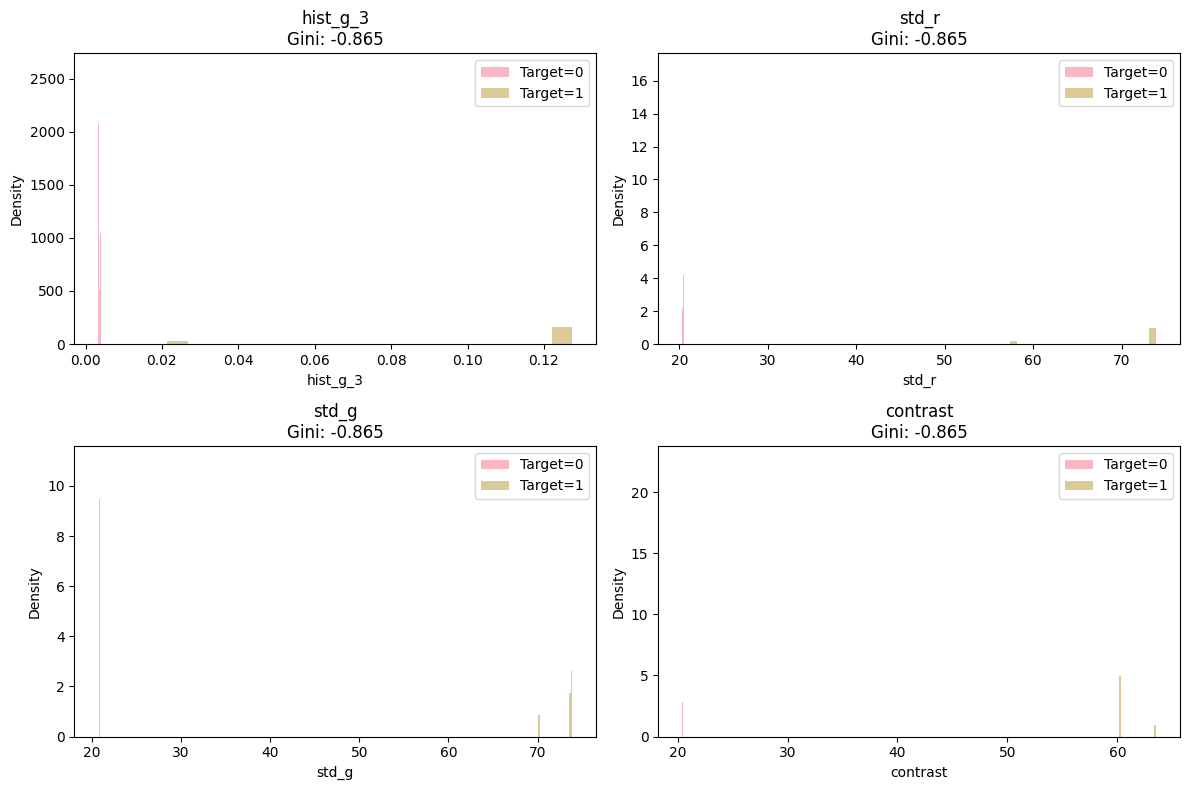

In [11]:
# Plot distributions of top image features by target
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, feature in enumerate(image_signal_strength.head(4)['column']):
    ax = axes[idx]
    
    # Plot distributions
    for target in [0, 1]:
        subset = df_with_features[df_with_features['target'] == target]
        ax.hist(subset[feature], bins=20, alpha=0.5, label=f'Target={target}', density=True)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.set_title(f'{feature}\nGini: {image_signal_strength.iloc[idx]["gini"]:.3f}')
    ax.legend()

plt.tight_layout()
plt.show()

# Analyze Image Features by Quantiles


Quantile Analysis for hist_g_3:
                   count  positive_cases  positive_rate  min_value  max_value  \
hist_g_3_quantile                                                               
Q1                    10               0            0.0     0.0033     0.0035   
Q2                    10               0            0.0     0.0035     0.0036   
Q3                    10               0            0.0     0.0037     0.0039   
Q4                    10               0            0.0     0.0039     0.0040   
Q5                    10               6            0.6     0.0041     0.1275   

                   mean_value  pct_of_total  
hist_g_3_quantile                            
Q1                     0.0034          20.0  
Q2                     0.0036          20.0  
Q3                     0.0038          20.0  
Q4                     0.0039          20.0  
Q5                     0.0666          20.0  


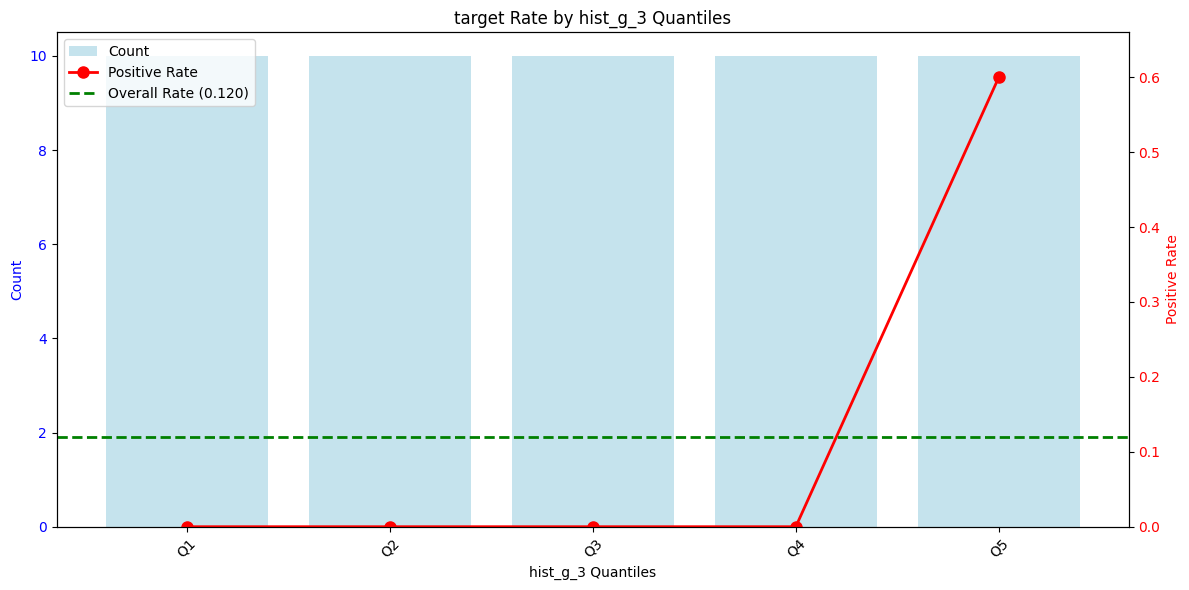


Quantile 1 (hist_g_3)
Range: 0.00 to 0.00
Target rate: 0.00%


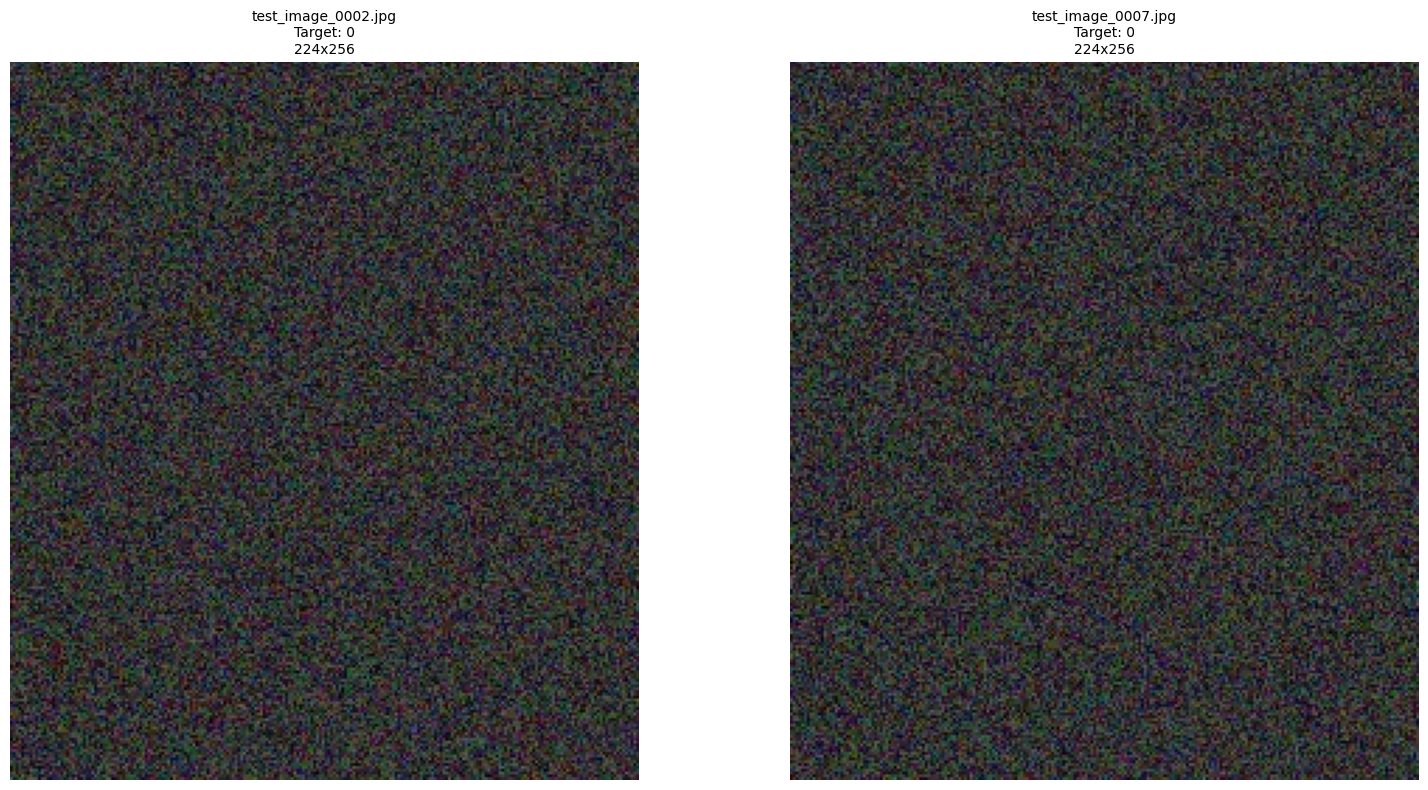


Quantile 2 (hist_g_3)
Range: 0.00 to 0.00
Target rate: 0.00%


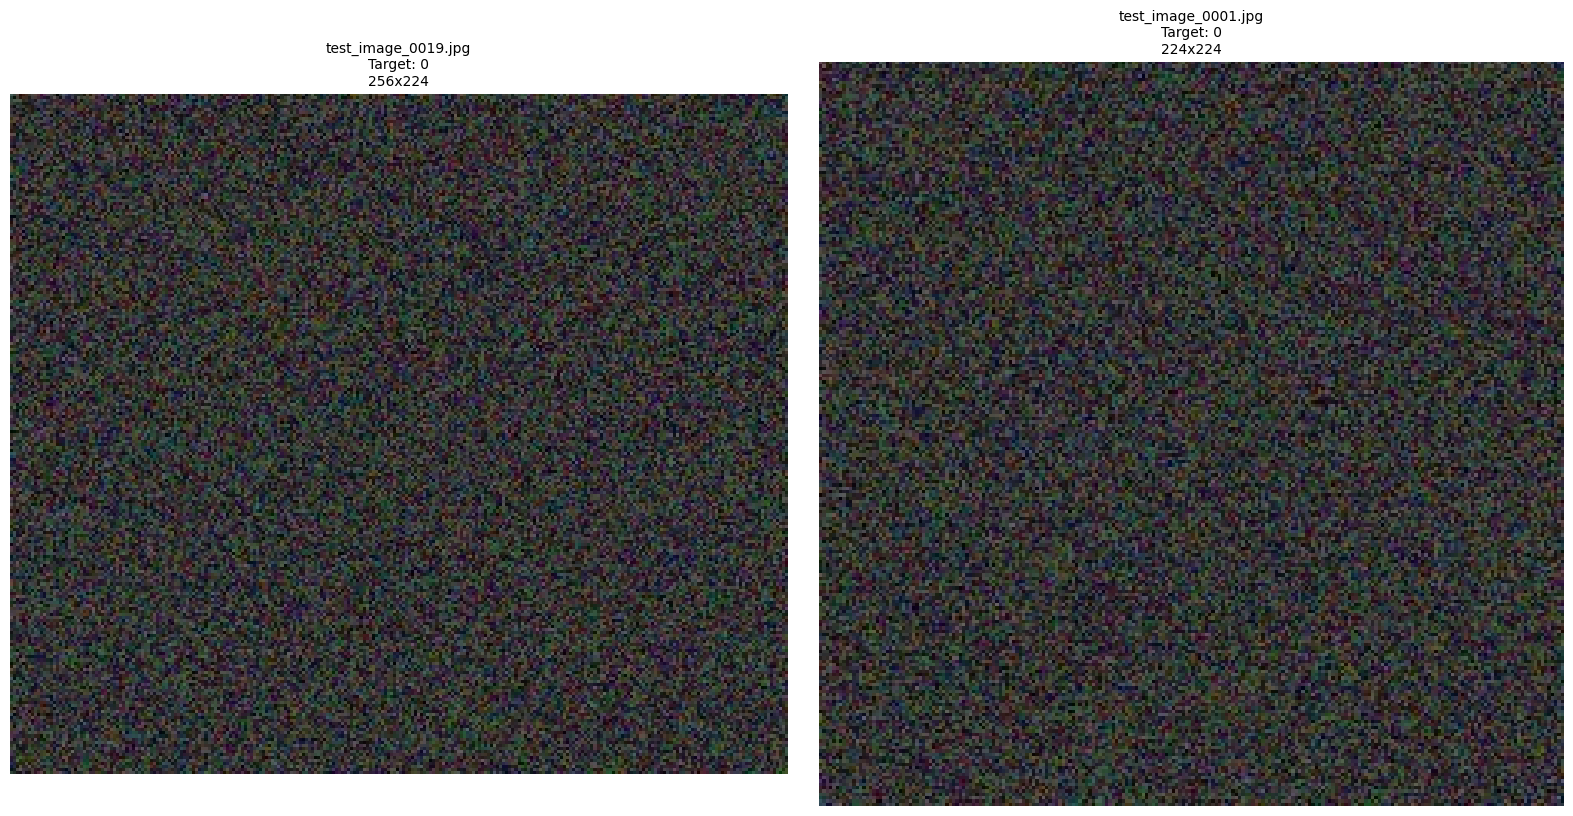


Quantile 3 (hist_g_3)
Range: 0.00 to 0.00
Target rate: 0.00%


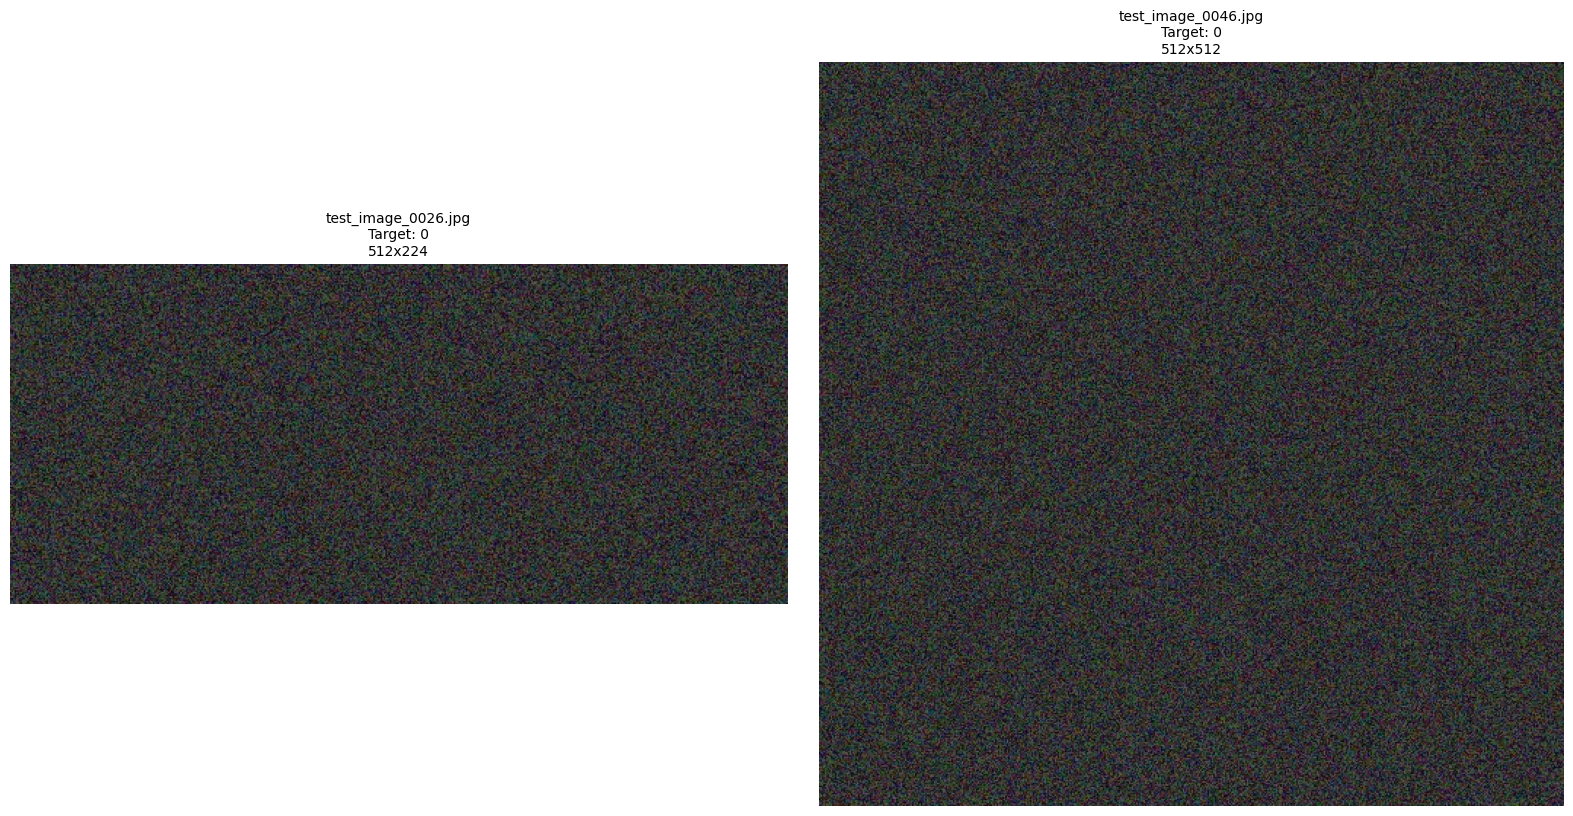


Quantile 4 (hist_g_3)
Range: 0.00 to 0.00
Target rate: 0.00%


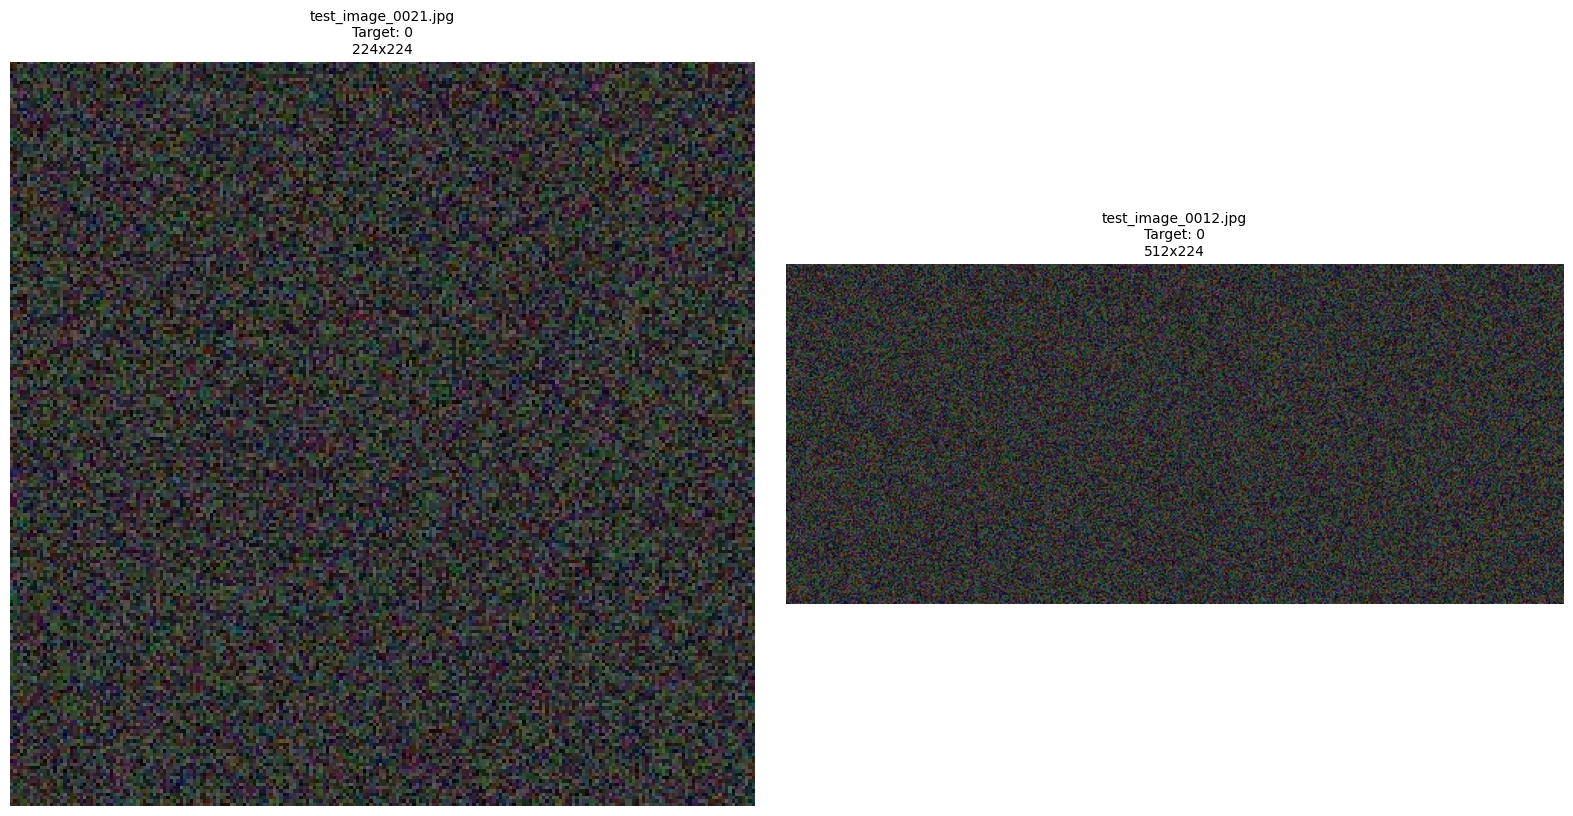


Quantile 5 (hist_g_3)
Range: 0.00 to 0.13
Target rate: 60.00%


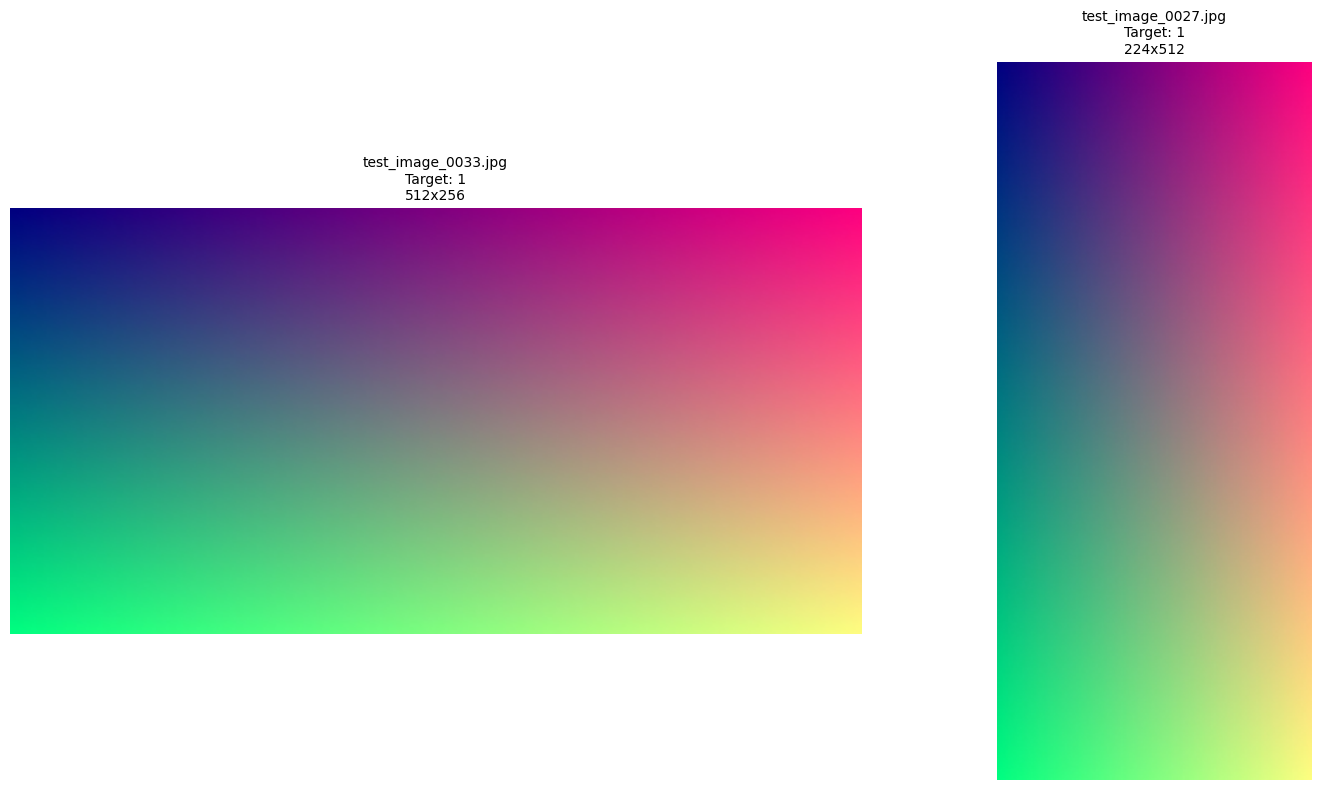

In [14]:
# Create quantile analysis for top image feature
top_feature = image_signal_strength.iloc[0]['column']
quantile_analysis = data_tools.analyze_by_quantiles(df_with_features, top_feature, 'target', n_quantiles=5)

print(f"\nQuantile Analysis for {top_feature}:")
print(quantile_analysis)

# Visualize relationship
data_tools.plot_quantile_analysis(df_with_features, top_feature, 'target', n_quantiles=5)

# Show example images from different quantiles
def show_images_by_quantile(df, feature, n_quantiles=5, images_per_quantile=2):
    # Create quantiles
    df_q = data_tools.create_quantile_bins(df, feature, n_quantiles)
    
    for q in range(1, n_quantiles+1):
        q_df = df_q[df_q[f'{feature}_quantile_num'] == q]
        print(f"\nQuantile {q} ({feature})")
        print(f"Range: {q_df[feature].min():.2f} to {q_df[feature].max():.2f}")
        print(f"Target rate: {q_df['target'].mean():.2%}")
        
        # Sample images
        sample = q_df.sample(min(images_per_quantile, len(q_df)))
        paths = sample['path'].tolist()
        labels = [f"Target: {row['target']}" for _, row in sample.iterrows()]
        
        photo_tools.plot_image_grid(paths, labels, n_cols=images_per_quantile)

# Show images by quantile of top feature
show_images_by_quantile(df_with_features, top_feature)

# Compare Image Features with Tabular Features

Signal Strength Comparison:
          column  correlation  max_lift      gini  missing_pct
3       hist_g_3     0.929717  7.333333 -0.864667         0.00
4          std_r     0.991847  7.333333 -0.864667         0.00
5          std_g     0.999592  7.333333 -0.864667         0.00
6       contrast     0.999470  7.333333 -0.864667         0.00
7       hist_r_3     0.905448  7.333333 -0.864667         0.00
2            age     0.073049  3.166667 -0.426667         0.00
1   credit_score    -0.044592  1.083333 -0.370400         0.06
0  annual_income     0.282917  2.333333 -0.295467         0.00

Analysis of target by membership_level
Overall target rate: 12.00%
+--------------------+---------+-------------+---------+----------------+--------------------+--------+------------+
| membership_level   |   count |   positives | rate    | pct_of_total   | pct_of_positives   |   lift | lift_pct   |
+====================+=========+=============+=========+================+====================+========+

TypeError: '<' not supported between instances of 'str' and 'float'

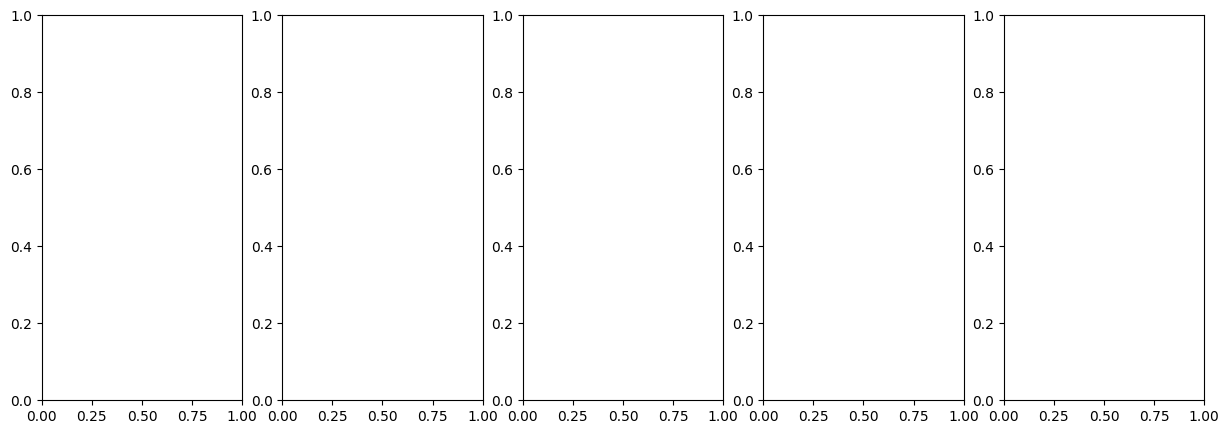

In [17]:
# Select best tabular features
tabular_features = ['annual_income', 'credit_score', 'age', 'membership_level']

# Combine with top image features
combined_features = tabular_features + image_signal_strength.head(5)['column'].tolist()

# Get signal strength for all features
combined_signal = data_tools.find_signal_strength(
    df_with_features[combined_features + ['target']], 
    'target',
    exclude_columns=['membership_level']  # Categorical handled differently
)

print("Signal Strength Comparison:")
print(combined_signal)

# Analyze categorical feature
data_tools.group_analyze(df_with_features, 'membership_level', 'target')

# Analyze cross-feature interaction
membership_levels = df_with_features['membership_level'].unique()
top_img_feature = image_signal_strength.iloc[0]['column']

# Create a grid of plots for each membership level
fig, axes = plt.subplots(1, len(membership_levels), figsize=(15, 5))

for i, level in enumerate(sorted(membership_levels)):
    ax = axes[i]
    subset = df_with_features[df_with_features['membership_level'] == level]
    
    # Plot histograms colored by target
    for target in [0, 1]:
        target_subset = subset[subset['target'] == target]
        ax.hist(target_subset[top_img_feature], alpha=0.5, bins=15, 
               label=f'Target={target}', density=True)
    
    ax.set_title(f'{level}\nTarget Rate: {subset["target"].mean():.2%}')
    ax.set_xlabel(top_img_feature)
    if i == 0:
        ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()

# BASELINE CREATION: Simple Model with Extracted Features

In [20]:
# Prepare data for modeling
# Select features
selected_image_features = image_signal_strength.head(5)['column'].tolist()
selected_tabular_features = ['annual_income', 'credit_score', 'age']

# Handle categorical variables
df_model = df_with_features.copy()
df_model = pd.get_dummies(df_model, columns=['membership_level', 'gender'], drop_first=True)

# Get all feature columns
feature_cols = selected_image_features + selected_tabular_features + [col for col in df_model.columns if col.startswith(('membership_level_', 'gender_'))]

# Prepare data
X_train, X_test, y_train, y_test, scaler = data_tools.prepare_features(
    df_model[feature_cols + ['target']], 
    target_col='target',
    test_size=0.2,
    scale=True
)

print(f"Training set: {X_train.shape}")
print(f"Feature columns: {len(feature_cols)}")

# Train a baseline model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

Training set: (40, 13)
Feature columns: 13


RandomForestClassifier(random_state=42)


Baseline Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

AUC: nan

Top 10 Features by Importance:
                      feature  importance     type
0                    hist_g_3    0.204179    image
2                       std_g    0.200284    image
4                    hist_r_3    0.196787    image
1                       std_r    0.162177    image
3                    contrast    0.150364    image
9   membership_level_Platinum    0.030692  tabular
5               annual_income    0.027267  tabular
6                credit_score    0.014290  tabular
7                         age    0.008359  tabular
10    membership_level_Silver    0.003353  tabular


<Figure size 1000x600 with 0 Axes>

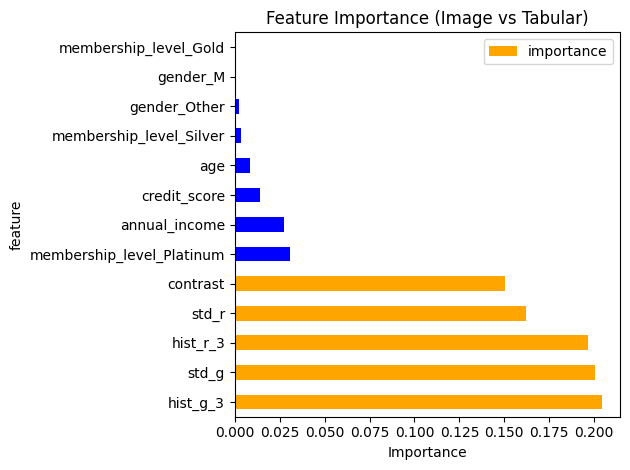

In [22]:
# Evaluate performance
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

print("\nBaseline Model Performance:")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

# Compare feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_,
    'type': ['image' if f in selected_image_features else 'tabular' for f in feature_cols]
}).sort_values('importance', ascending=False)

print("\nTop 10 Features by Importance:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
importance_df.head(15).plot.barh(x='feature', y='importance', color=importance_df.head(15)['type'].map({'image': 'orange', 'tabular': 'blue'}))
plt.xlabel('Importance')
plt.title('Feature Importance (Image vs Tabular)')
plt.tight_layout()
plt.show()


AUC Comparison:
Image Only: nan
Tabular Only: nan
Combined: nan


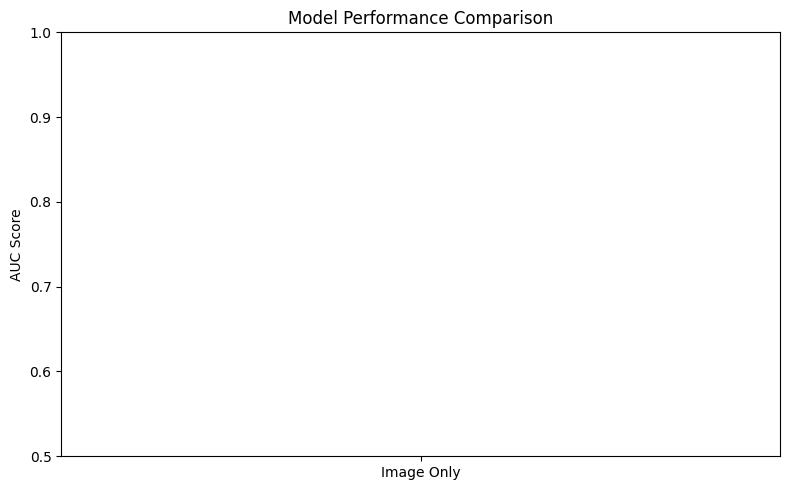

In [23]:
# Compare model with only tabular vs only image vs combined
def compare_feature_types(X_train, X_test, y_train, y_test, image_features, tabular_features):
    results = {}
    
    # Image features only
    rf_img = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_img.fit(X_train[image_features], y_train)
    y_pred_img = rf_img.predict_proba(X_test[image_features])[:, 1]
    img_auc = roc_auc_score(y_test, y_pred_img)
    results['Image Only'] = img_auc
    
    # Tabular features only
    rf_tab = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_tab.fit(X_train[tabular_features], y_train)
    y_pred_tab = rf_tab.predict_proba(X_test[tabular_features])[:, 1]
    tab_auc = roc_auc_score(y_test, y_pred_tab)
    results['Tabular Only'] = tab_auc
    
    # Combined features
    rf_comb = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_comb.fit(X_train, y_train)
    y_pred_comb = rf_comb.predict_proba(X_test)[:, 1]
    comb_auc = roc_auc_score(y_test, y_pred_comb)
    results['Combined'] = comb_auc
    
    return results

# Get image and tabular feature columns from X_train
img_cols = [col for col in X_train.columns if col in selected_image_features]
tab_cols = [col for col in X_train.columns if col not in img_cols]

# Compare performance
comparison = compare_feature_types(X_train, X_test, y_train, y_test, img_cols, tab_cols)
print("\nAUC Comparison:")
for model_type, auc in comparison.items():
    print(f"{model_type}: {auc:.3f}")

# Plot comparison
plt.figure(figsize=(8, 5))
plt.bar(comparison.keys(), comparison.values())
plt.ylabel('AUC Score')
plt.title('Model Performance Comparison')
plt.ylim(0.5, 1.0)
for i, (k, v) in enumerate(comparison.items()):
    plt.text(i, v+0.01, f'{v:.3f}', ha='center')
plt.tight_layout()
plt.show()

# Error Analysis with Images

In [24]:
# Identify errors
df_test = df_model.iloc[X_test.index].copy()
df_test['predicted'] = y_pred
df_test['predicted_proba'] = y_pred_proba
df_test['correct'] = df_test['predicted'] == df_test['target']

# Find misclassified examples
errors = df_test[~df_test['correct']]
print(f"Total errors: {len(errors)} out of {len(df_test)} ({len(errors)/len(df_test):.1%})")

# Show some false positives and false negatives
false_positives = errors[(errors['target'] == 0) & (errors['predicted'] == 1)]
false_negatives = errors[(errors['target'] == 1) & (errors['predicted'] == 0)]

print(f"\nFalse Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

# Show sample errors
def show_error_examples(errors, n_samples=3):
    if len(errors) == 0:
        print("No errors found.")
        return
        
    sample = errors.sample(min(n_samples, len(errors)))
    
    paths = sample['path'].tolist()
    labels = [f"True: {row['target']}, Pred: {row['predicted']}\nProb: {row['predicted_proba']:.2f}" 
             for _, row in sample.iterrows()]
    
    plot_image_grid(paths, labels=labels, n_cols=n_samples)

print("\nFalse Positive Examples:")
show_error_examples(false_positives)

print("\nFalse Negative Examples:")
show_error_examples(false_negatives)

# Analyze errors by feature values
top_feature = image_signal_strength.iloc[0]['column']
error_rate_by_quantile = df_test.groupby(pd.qcut(df_test[top_feature], 5))['correct'].mean()

print(f"\nAccuracy by {top_feature} Quantiles:")
print(error_rate_by_quantile)

Total errors: 0 out of 10 (0.0%)

False Positives: 0
False Negatives: 0

False Positive Examples:
No errors found.

False Negative Examples:
No errors found.

Accuracy by hist_g_3 Quantiles:
hist_g_3
(0.00241, 0.00344]    1.0
(0.00344, 0.00355]    1.0
(0.00355, 0.00365]    1.0
(0.00365, 0.00383]    1.0
(0.00383, 0.00389]    1.0
Name: correct, dtype: float64


# Summary and Next Steps

In [25]:
# Print summary
print("\n=== SUMMARY ===")
print(f"Total features: {len(feature_cols)}")
print(f"Image features: {len(selected_image_features)}")
print(f"Tabular features: {len(selected_tabular_features) + len([c for c in feature_cols if c.startswith(('membership_level_', 'gender_'))])}")
print(f"\nBaseline model AUC: {comparison['Combined']:.3f}")
print(f"- Tabular only: {comparison['Tabular Only']:.3f}")
print(f"- Image only: {comparison['Image Only']:.3f}")

print("\nTop image features:")
for _, row in image_signal_strength.head(3).iterrows():
    print(f"- {row['column']}: Gini = {row['gini']:.3f}")

print("\nNext steps:")
print("1. Train a simple CNN model as next baseline")
print("2. Use transfer learning (e.g., ResNet, EfficientNet)")
print("3. Build multimodal architecture combining tabular and image data")
print("4. Implement feature attribution for model interpretability")


=== SUMMARY ===
Total features: 13
Image features: 5
Tabular features: 8

Baseline model AUC: nan
- Tabular only: nan
- Image only: nan

Top image features:
- hist_g_3: Gini = -0.865
- std_r: Gini = -0.865
- std_g: Gini = -0.865

Next steps:
1. Train a simple CNN model as next baseline
2. Use transfer learning (e.g., ResNet, EfficientNet)
3. Build multimodal architecture combining tabular and image data
4. Implement feature attribution for model interpretability
